In [13]:
# Sequential model allows you to build a neural network layer by layer
# ImageDataGenerator is used for augmenting image dataduring training.
# Layers needed for building a Convolutional Neural Network (CNN).
    # Conv2D - for applying convolutional filters.
    # MaxPooling2D - for downsampling the input representation.
    # Dense - fully connected layer for classification.
    # Dropout - for regularization to prevent overfitting.
    # Flatten - for flattening 2D inputs into 1D for Dense layers.
    # Input - defines the input shape of the data.
# Adam optimizer is an optimization algorithm that can be used to update the model's weights during training.
# ExponentialDecay is used to gradually reduce the learning rate during training.
# Matplotlib is used for plotting graphs, such as training accuracy and loss curves.
# Path is used for handling file paths in a way that's independent of the operating system.
# OS module for interacting with the operating system for finding files and directories

from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
import matplotlib.pyplot as plt
from pathlib import Path
import os

# Set the train & test data paths using Path objects
train_data_path = Path('/kaggle/input/fer2013/train/')
test_data_path = Path('/kaggle/input/fer2013/test/') 

# Define batch size and number of epochs
batch_size = 64  # Number of images processed at once
epochs = 100     # Number of complete passes through the training dataset


In [14]:
def dataPreProcessor():    
    # Define data augmentation and preprocessing parameters for training and testing
    # Rescale pixel values which typically have values between 0 and 255, to a range between 0 and 1.
    
    data_gen_args = dict(rescale=1./255) 
    
    train_datagenerator = ImageDataGenerator(**data_gen_args)
    test_datagenerator = ImageDataGenerator(**data_gen_args)

    # Preprocess the training data from the specified train directory
    train_generator = train_datagenerator.flow_from_directory(
        train_data_path,  # Path to the training data directory
        color_mode='grayscale',  # Use grayscale color mode for the images
        target_size=(48, 48),  # Resize all images to 48x48 pixels
        batch_size=batch_size,  # Number of images to be defer from the generator per batch
        class_mode='categorical'  # Use categorical labels for multi-class classification
    )

    # Preprocess the test data from the specified test directory
    test_generator = test_datagenerator.flow_from_directory(
        test_data_path,  # Path to the test data directory
        color_mode='grayscale',  # Use grayscale color mode for the images
        target_size=(48, 48),  # Resize all images to 48x48 pixels
        batch_size=batch_size,  # Number of images to be defer from the generator per batch
        class_mode='categorical'  # Use categorical labels for multi-class classification
    )

    return train_generator, test_generator


In [15]:
def FeatureExtraction():
    # Learning rate schedule to gradually decrease the learning rate during training
    lr_schedule = ExponentialDecay(
        initial_learning_rate=0.0001,  # Starting learning rate
        decay_steps=100000,             # Number of steps before the learning rate is reduced
        decay_rate=0.96,                # Factor by which the learning rate is reduced
        staircase=True                  # Whether to apply decay in a staircase manner
    )

    # Define the model architecture using a Sequential model
    model = Sequential([
        Input(shape=(48, 48, 1)),  # Input layer for 48x48 grayscale images 
        Conv2D(32, kernel_size=(3, 3), activation='relu'),  # First convolutional layer with 32 filters
        Conv2D(64, kernel_size=(3, 3), activation='relu'),  # Second convolutional layer with 64 filters
        MaxPooling2D(pool_size=(2, 2)),  # Max pooling layer to downsample the feature maps
        Dropout(0.25),  # Dropout layer to prevent overfitting (25% of neurons dropped)
        
        Conv2D(128, kernel_size=(3, 3), activation='relu'),  # Third convolutional layer with 128 filters
        MaxPooling2D(pool_size=(2, 2)),  # Another max pooling layer
        Conv2D(128, kernel_size=(3, 3), activation='relu'),  # Fourth convolutional layer
        MaxPooling2D(pool_size=(2, 2)),  # Max pooling layer
        Dropout(0.25),  # Dropout layer to prevent overfitting (25% of neurons dropped)
        
        Flatten(),  # Flatten the 3D outputs to 1D array for the Dense layers
        Dense(1024, activation='relu'),  # Fully connected layer with 1024 neurons
        Dropout(0.5),  # Dropout layer to prevent overfitting (50% of neurons dropped)
        Dense(7, activation='softmax')  # Output layer with 7 neurons which means catergories (sad, happy....)
    ])

    # Compile the model with the Adam optimizer and categorical crossentropy loss
    model.compile(optimizer=Adam(learning_rate=lr_schedule), 
                  loss='categorical_crossentropy',  
                  metrics=['accuracy'])  

    # Print the model summary to show the architecture and number of parameters
    model.summary()
    
    return model  


In [16]:
def TrainAndValidate(model, train_generator, test_generator):
    # Counting the number of images in the training and test directories
    num_train_images = len(list(train_data_path.glob('**/*.png'))) 
    num_test_images = len(list(test_data_path.glob('**/*.png')))    

    # Train the model using the training data generator
    result = model.fit(train_generator, 
                        steps_per_epoch=num_train_images // batch_size,  # Number of batches per epoch
                        epochs=epochs,  # Total number of epochs to train the model
                        validation_data=test_generator,  # Data generator for validation images
                        validation_steps=num_test_images // batch_size  # Number of validation batches
    )

    # Save the trained model as an H5 file
    model.save('/kaggle/working/visual_trained_model.h5')  
    return result 


In [17]:
def DataVisualization(result):
    # Visualize training/test loss and accuracy
    train_loss = result.history['loss']
    test_loss = result.history['val_loss']
    train_accuracy = result.history['accuracy']
    test_accuracy = result.history['val_accuracy']

    fig, ax = plt.subplots(ncols=2, figsize=(15, 7))
    ax = ax.ravel()

    ax[0].plot(train_loss, label='Train Loss', color='royalblue', marker='o', markersize=5)
    ax[0].plot(test_loss, label='Test Loss', color='orangered', marker='o', markersize=5)
    ax[0].set_xlabel('Epochs', fontsize=14)
    ax[0].set_ylabel('Loss (Categorical Crossentropy)', fontsize=14)
    ax[0].legend(fontsize=14)
    ax[0].tick_params(axis='both', labelsize=12)

    ax[1].plot(train_accuracy, label='Train Accuracy', color='royalblue', marker='o', markersize=5)
    ax[1].plot(test_accuracy, label='Test Accuracy', color='orangered', marker='o', markersize=5)
    ax[1].set_xlabel('Epochs', fontsize=14)
    ax[1].set_ylabel('Accuracy', fontsize=14)
    ax[1].legend(fontsize=14)
    ax[1].tick_params(axis='both', labelsize=12)

    fig.suptitle('Training and Validation Loss/Accuracy Over Epochs', fontsize=16)
    plt.tight_layout()
    plt.show()

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 46, 46, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 44, 44, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 20, 20, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 7)              │         7,175 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,345,607 (8.95 MB)

 Trainable params: 2,345,607 (8.95 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 40s 74ms/step - accuracy: 0.2464 - loss: 1.8309 - val_accuracy: 0.3143 - val_loss: 1.7328
Epoch 2/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 30s 67ms/step - accuracy: 0.3384 - loss: 1.6744 - val_accuracy: 0.4081 - val_loss: 1.5326
Epoch 3/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 29s 63ms/step - accuracy: 0.4063 - loss: 1.5332 - val_accuracy: 0.4405 - val_loss: 1.4558
Epoch 4/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 37s 81ms/step - accuracy: 0.4431 - loss: 1.4486 - val_accuracy: 0.4706 - val_loss: 1.3807
Epoch 5/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 31s 69ms/step - accuracy: 0.4707 - loss: 1.3842 - val_accuracy: 0.5013 - val_loss: 1.3261
Epoch 6/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 39s 85ms/step - accuracy: 0.4949 - loss: 1.3397 - val_accuracy: 0.5117 - val_loss: 1.2869
Epoch 7/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 30s 67ms/step - accuracy: 0.5095 - loss: 1.2940 - val_accuracy: 0.5249 - val_loss: 1.2525
Epoch 8/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 28s 61ms/step - accuracy: 0.5281 - loss: 1

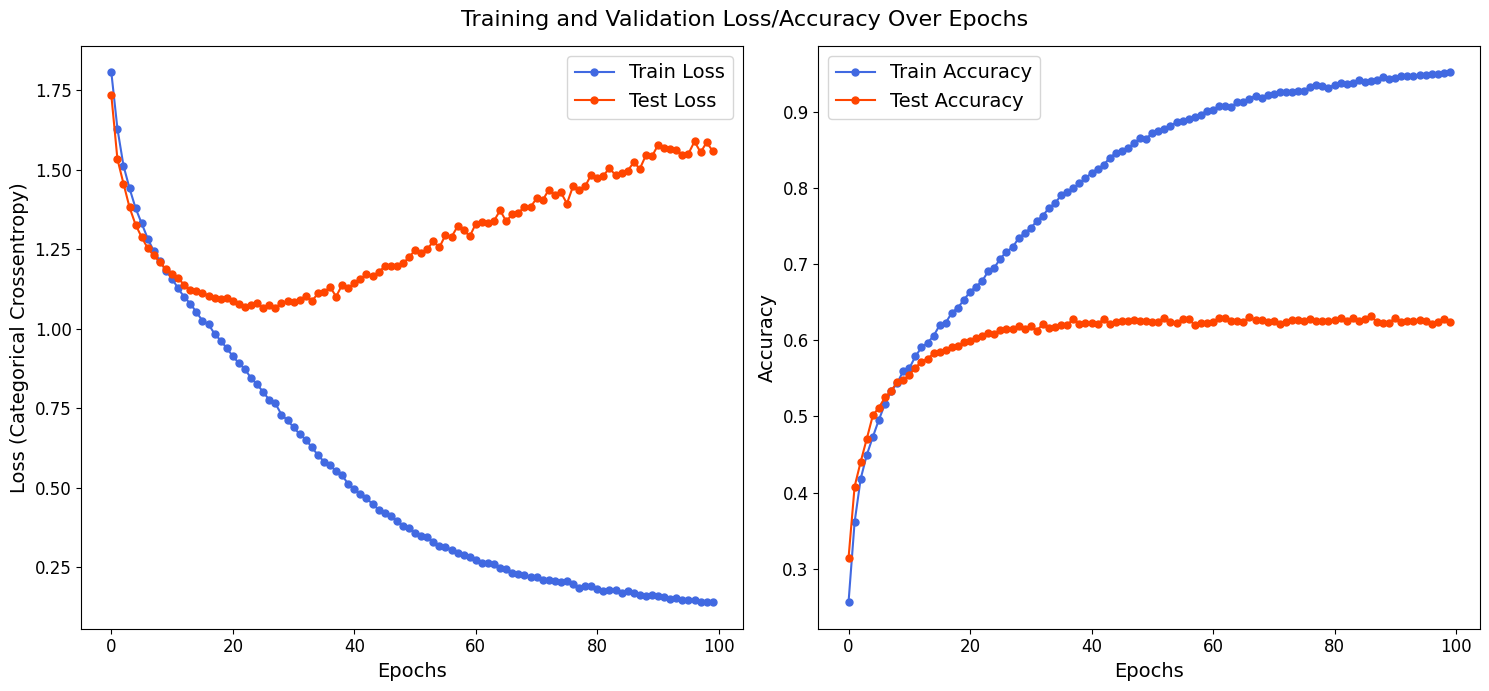

In [18]:
# Call the methods
train_generator, test_generator = dataPreProcessor()
model = FeatureExtraction()
result = TrainAndValidate(model, train_generator, test_generator)
DataVisualization(result)